In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists
from scipy.special import logsumexp



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#data import
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
tags_df=pd.read_csv("tags.csv")
movies_df=pd.read_csv("movies.csv")

In [3]:
train_df.head(2)

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739


In [4]:
tags_df.head(2)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256


In [5]:
movies_df.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [6]:
train_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
test_df.head(2)

,userId,movieId
0,5,788
1,68,7438


In [8]:
train_df=train_df.drop(["timestamp"],axis=1)

In [9]:
train_df.head(2)

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5


In [10]:
sampled_df=train_df.sample(n=7000,random_state=42)

In [11]:
sampled_df.shape

(7000, 3)

In [12]:
sampled_df.head()

,userId,movieId,rating
5954604,122380,31445,2.5
1460784,22380,56775,4.0
6631832,104339,356,2.5
5396407,64877,6874,4.0
8150654,63164,2762,5.0


In [13]:
sampled_df.describe()

,userId,movieId,rating
count,7000.000000,7000.000000,7000.000000
mean,81022.543429,20813.089143,3.545857
std,46483.736255,38219.833884,1.041727
min,2.000000,1.000000,0.500000
25%,40650.250000,1200.000000,3.000000
50%,80759.000000,2878.000000,4.000000
75%,120268.250000,8531.500000,4.000000
max,162521.000000,205425.000000,5.000000


C:\Users\JMOSOLA\Anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\JMOSOLA\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Average rating in dataset: 3.545857142857143


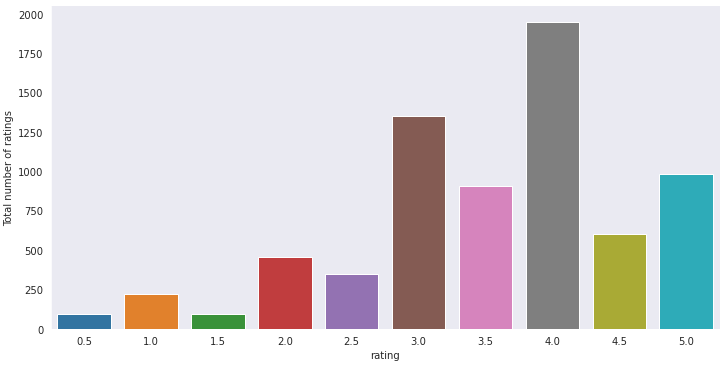

In [17]:
with sns.axes_style('dark'):
    g = sns.factorplot("rating", data=sampled_df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(sampled_df["rating"])}')

In [18]:
user_movie_counts=sampled_df.groupby('userId')['movieId'].count()

In [19]:
user_movie_counts.sort_values(ascending=False)

userId
72315     13
80974      5
40211      4
70597      4
63019      4
          ..
57282      1
57246      1
57142      1
57133      1
162521     1
Name: movieId, Length: 6515, dtype: int64

In [20]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 5954604 to 7546636
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   7000 non-null   int64  
 1   movieId  7000 non-null   int64  
 2   rating   7000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 218.8 KB


In [24]:
utility_matrix = sampled_df.pivot_table(index=['userId'], 
                                       columns=['movieId'],
                                       values='rating',
                                    fill_value=0,
                                    aggfunc='mean') 

In [25]:
utility_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,196417,196915,197199,197649,197879,198789,201242,203334,203881,205425
userId,,,,,,,,,,,,,,,,,,,,,
2,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
12,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
59,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
80,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
120,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162368,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
162457,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0
162465,0,0.0,0.0,0,0,0,0.0,0,0,0.0,...,0,0.0,0,0,0,0,0,0,0,0


In [26]:
utility_matrix.isnull().sum()

movieId
1         0
2         0
3         0
4         0
5         0
         ..
198789    0
201242    0
203334    0
203881    0
205425    0
Length: 2991, dtype: int64

In [27]:
utility_matrix[2]

userId
2         0.0
12        0.0
59        0.0
80        0.0
120       0.0
         ... 
162368    0.0
162457    0.0
162465    0.0
162512    0.0
162521    0.0
Name: 2, Length: 6515, dtype: float64

In [29]:
util_matrix_Trans= utility_matrix.T
util_matrix_Trans = util_matrix_Trans.loc[:, (util_matrix_Trans != 0).any(axis=0)]
# Save the utility matrix in scipy's sparse matrix format
sparse_matrix = sp.sparse.csr_matrix(util_matrix_Trans.values)

In [31]:
# Compute the similarity matrix using the cosine similarity metric
user_similarity = cosine_similarity(sparse_matrix.T)
# Save the matrix as a dataframe to allow for easier indexing  
user_sim_df = pd.DataFrame(user_similarity, 
                           index = util_matrix_Trans.columns, 
                           columns = util_matrix_Trans.columns)

# Review a small portion of the constructed similartiy matrix  
user_sim_df[:5]

userId,2,12,59,80,120,123,141,166,175,296,...,162176,162188,162226,162271,162278,162368,162457,162465,162512,162521
userId,,,,,,,,,,,,,,,,,,,,,
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
user_sim_df[2]

In [32]:
def top_N_recommendations(userId, N=10, k=20):
    # Cold-start problem - no ratings given by the reference user. 
    # With no further user data, we solve this by simply recommending
    # the top-N most popular books in the item catalog. 
    if userId not in user_sim_df.columns:
        return train_df.groupby('movieId').mean().sort_values(by='rating',
                                        ascending=False).index[:N].to_list()
    
    # Gather the k users which are most similar to the reference user 
    sim_users = user_sim_df.sort_values(by=userId, ascending=False).index[1:k+1]
    top_items = [] # <-- List of highest rated items gathered from the k users  
    top_common_items = {} # <-- Dictionary of highest rated items in common for the k users
    
    for i in sim_users:
        # Maximum rating given by the current user to an item 
        max_score = util_matrix_Trans.loc[:, i].max()
        # Save the names of items maximally rated by the current user   
        top_items.append(util_matrix_Trans[util_matrix_Trans.loc[:, i]==max_score].index.tolist())
        
    # Loop over each user's favorite items and tally which ones are 
    # most popular overall.
    for item_collection in range(len(top_items)):
        for item in top_items[item_collection]: 
            if item in top_common_items:
                top_common_items[item] += 1
            else:
                top_common_items[item] = 1
    # Sort the overall most popular items and return the top-N instances
    sorted_list = sorted(top_common_items.items(), key=operator.itemgetter(1), reverse=True)[:N]
    top_N = [x[0] for x in sorted_list]
    return top_N  

In [33]:
top_N_recommendations(2)

[5418, 1374, 8622, 441, 1089, 122882]

In [34]:
# User 2's historical ratings
sampled_df[sampled_df['userId'] == 2][:][['movieId','rating']].sort_values(by='rating', ascending=False)[:10]

,movieId,rating
641966,5418,5.0


In [35]:
def rounder(x, base=0.5):
    if x<0.5:
        result=0.5
    elif x>5:
        result = 5.0
    else:
        result=base * round(x/base)
    return result

In [95]:
rounder(0,5)

In [36]:
def rating_predictor(movieId, userId, k=20, threshold=0.0):
    # Gather the k users which are most similar to the reference user 
    if movieId in utility_matrix.columns and userId in user_sim_df.columns:
        sim_users = user_sim_df.sort_values(by=userId, ascending=False).index[1:k+1]
        # Store the corresponding user's similarity values 
        user_sim_values = user_sim_df.sort_values(by=userId, ascending=False).loc[:,userId].tolist()[1:k+1]
        rating_list = [] # <-- List of k user's ratings for the reference item
        weight_list = [] # <-- List of k user's similarities to the reference user

        # Create a weighted sum for each of the k users who have rated the 
        # reference item (book).
        for x, user_id in enumerate(sim_users):
            # User's rating of the item
            rating = utility_matrix.loc[user_id, movieId]
            # User's similarity to the reference user 
            similarity = user_sim_values[x]
            # Skip the user if they have not rated the item, or are too dissimilar to 
            # the reference user
            if (np.isnan(rating)) or (similarity < threshold):
                continue
            elif not np.isnan(rating):
                rating_list.append(rating*similarity)
                weight_list.append(similarity)
        array1 =np.array(rating_list)
        array2 =np.array(weight_list)
        try:
            # Return the weighted sum as the predicted rating for the reference item
            pred_rating = np.exp(logsumexp(-3*array1) - logsumexp(-3*array2)) 
        except ZeroDivisionError:
            # If no ratings for the reference item can be collected, return the average 
            # rating given by all users for the item.  
            pred_rating = sampled_df.loc[sampled_df['movieId'] == movieId, 'rating'].mean()
    elif movieId not in utility_matrix.columns and userId in user_sim_df.columns:
        pred_rating = sampled_df.loc[sampled_df['userId'] == userId, 'rating'].mean()
    elif movieId in utility_matrix.columns and userId not in user_sim_df.columns:
        pred_rating = sampled_df.loc[sampled_df['movieId'] == movieId, 'rating'].mean()
    else:
        pred_rating = train_df['rating'].mean()
    return rounder(pred_rating)

In [37]:
rating_predictor(5418,2)

1.0

In [38]:
movie_id = 5418
actual_rating = train_df[(train_df['userId'] == 2) & (train_df['movieId'] == movie_id)]['rating'].values[0]
predicted_rating = rating_predictor(movieId = movie_id, userId = 2)
print (f"movieId - {movie_id}")
print ("---")
print (f"Actual rating: \t\t {actual_rating}")
print (f"Predicted rating: \t {predicted_rating}")

movieId - 5418
---
Actual rating: 		 5.0
Predicted rating: 	 1.0


In [75]:
test_df.head()

In [39]:
rating_predictor(441,2)

3.5

In [40]:
test_df.head(2)

,userId,movieId
0,5,788
1,68,7438


In [41]:
test_df['pred_rating'] = test_df.apply(lambda x: rating_predictor(x['movieId'], x['userId']), axis=1)

In [81]:
test_df.head(10)

In [82]:
def int_to_str(S, I):
    return str(int(S))+'_'+str(int(I))

In [83]:
test_df['Id'] = test_df.apply(lambda x: int_to_str(x['userId'], x['movieId']), axis=1)

In [84]:
test_df.head()

In [85]:
final_df = test_df[['Id','pred_rating']]

In [86]:
final_df.head()

In [87]:
final_df['rating']=outer2['pred_rating']

In [88]:
submission=final_df.drop(["pred_rating"],axis=1)

In [89]:
submission.to_csv("Julia_Mosola_Submission.csv", index=False)